In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
import copy
import re
from collections import Counter
import matplotlib.pyplot as plt
import nltk

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import torch, torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [2]:
"""

loading pre-prepared data from a validation set.

one recipe:

-categories  : some global information
-directions  : text description of cooking steps
-ingredients : array: [qantyty, qantyty_measurment, ingridient_name, ingridient_preparing] X number_of_ingr

"""

data_desert  = np.load("_data_/_recipes_/data_desert.npy")
data_beef    = np.load("_data_/_recipes_/data_beef.npy")
data_chicken = np.load("_data_/_recipes_/data_chicken.npy")
data_fish    = np.load("_data_/_recipes_/data_fish.npy")
data_pizza   = np.load("_data_/_recipes_/data_pizza.npy")

In [3]:
"""

loading pre-prepared tokens for each tasks:

tokens_inrgidients : all ingredient tokens
tokens_how_cook    : all ingredient preparing configuration
tokens_quantity    : all quantyty measurement tokens
tokens_main        : all words tokens for description
qantyty_measure    : ingredient measurement map

"""


tokens_inrgidients = np.load("_data_/_tokens_/tokens_inrgidients.npy" )
tokens_how_cook    = np.load("_data_/_tokens_/tokens_how_cook.npy" ) 
tokens_quantity    = np.load("_data_/_tokens_/tokens_quantity.npy"  )
tokens_main        = np.load("_data_/_tokens_/tokens_discription.npy" ) 
qantyty_measure    = np.load("_data_/_tokens_/qantyty_measure.npy")



In [4]:
"""

dict tokenizing map words to numbers

"""

ingr_to_num = {v: i+3 for i, v in enumerate(tokens_inrgidients)}
num_to_ingr = {i: v for v, i in ingr_to_num.items()}

how_to_num = {v: i+3 for i, v in enumerate(tokens_how_cook)}
num_to_how = {i: v for v, i in how_to_num.items()}

quant_to_num = {v: i+3 for i, v in enumerate(tokens_quantity)}
num_to_quant = {i: v for v, i in quant_to_num.items()}

main_to_num = {v: i+3 for i, v in enumerate(tokens_main)}
num_to_main = {i: v for v, i in main_to_num.items()}

n_tokens_ingr = max(num_to_ingr) + 1
n_tokens_quant = max(num_to_quant) + 1
n_tokens_how = max(num_to_how) + 1
n_tokens_main =  max(num_to_main) + 1

In [5]:
#PADDDINGS

PAD_ix = 0    #for padding - end of sequences
START_ix = 1  #start index for some LSTM
NULL_ix = 2   #index for Nones

LEN_SEQ = 20


In [6]:
"""

Extra indexing for padding and NULLs

"""

num_to_ingr[PAD_ix] , num_to_ingr[START_ix], num_to_ingr[NULL_ix] = "", "", ""
num_to_quant[PAD_ix] , num_to_quant[START_ix], num_to_quant[NULL_ix] = "", "", ""
num_to_how[PAD_ix] , num_to_how[START_ix], num_to_how[NULL_ix] = "", "", ""

quant_to_num[""] = NULL_ix
num_to_quant[NULL_ix] = ""

how_to_num[""] = NULL_ix
num_to_how[NULL_ix] = ""


In [7]:
"""

Word2Vec for our tokens 

See more in .......

"""



matrix_for_embedding = np.load("_data_/_w2v_/matrix_for_embedding.npy")
matrix_for_embedding_main = np.load("_data_/_w2v_/matrix_for_embedding_main.npy")

# BATCH generator / vectorizer

In [8]:
from _utils_._vectorizer_ import vectorizer, one_hot_encoding, one_hot_encoding_fix, one_hot_encoding_small

from _utils_._vectorizer_ import sample_data_batch, sample_data_batch_not_shuffle

In [9]:
data_vectorized_des = []
data_vectorized_beef = []
data_vectorized_fish = []
data_vectorized_chicken = []
data_vectorized_pizza = []


for recipe_ in (data_beef):
    ingr = recipe_["ingredients"]
    data_vectorized_beef.append(vectorizer(ingr, ingr_to_num, quant_to_num, how_to_num, LEN_SEQ=LEN_SEQ))

data_vectorized_beef = np.array(data_vectorized_beef)

for recipe_ in (data_desert):
    ingr = recipe_["ingredients"]
    data_vectorized_des.append(vectorizer(ingr, ingr_to_num, quant_to_num, how_to_num, LEN_SEQ=LEN_SEQ))

data_vectorized_des = np.array(data_vectorized_des)

for recipe_ in (data_fish):
    ingr = recipe_["ingredients"]
    data_vectorized_fish.append(vectorizer(ingr, ingr_to_num, quant_to_num, how_to_num, LEN_SEQ=LEN_SEQ))
    
data_vectorized_fish = np.array(data_vectorized_fish)

for recipe_ in (data_chicken):
    ingr = recipe_["ingredients"]
    data_vectorized_chicken.append(vectorizer(ingr, ingr_to_num, quant_to_num, how_to_num, LEN_SEQ=LEN_SEQ))

data_vectorized_chicken = np.array(data_vectorized_chicken)


for recipe_ in (data_pizza):
    ingr = recipe_["ingredients"]
    data_vectorized_pizza.append(vectorizer(ingr, ingr_to_num, quant_to_num, how_to_num, LEN_SEQ=LEN_SEQ))

data_vectorized_pizza = np.array(data_vectorized_pizza)

In [10]:
batch_size = 10
with torch.no_grad():
    for batch in sample_data_batch(batch_size,data_vectorized_pizza, n_tokens_ingr , n_tokens_quant , n_tokens_how , LEN_SEQ):
        print(batch["ingridients_one_hot"].shape)
        break

torch.Size([10, 20, 913])


# CREATE MODEL

In [11]:
from _models_._utils_ import EMBEDDING_LAYER, SMALL_V2V

In [12]:
"""

MODELS for generation quantyty and preparing configuration


"""



mod_numbers = SMALL_V2V(matrix_for_embedding, n_tokens = n_tokens_quant).cpu()
mod_how = SMALL_V2V(matrix_for_embedding, n_tokens = n_tokens_how).cpu()



chkpt1 = torch.load("_models_/_weights_/mod_numbers",map_location="cpu")
mod_numbers.load_state_dict(chkpt1)

chkpt2 = torch.load("_models_/_weights_/mod_how", map_location="cpu")
mod_how.load_state_dict(chkpt2)



In [13]:
from _models_._utils_ import decoder, Generator,Classifier



class mymodel(nn.Module):
    def __init__(self , matrix_for_embedding , n_tokens_ingr, LEN_SEQ):
        super(self.__class__, self).__init__()
        """
        AutoEncoder analog system
        
        """
        self.dec = decoder(matrix_for_embedding,  n_tokens_ingr, emb_size=100, out_size=30, lstm_units=60)
        self.enc = Generator(matrix_for_embedding, LEN_SEQ,  n_tokens_ingr, emb_size=100, lstm_units=100, rand_inp=50)

        self.emb = EMBEDDING_LAYER(matrix_for_embedding)
        self.cls = Classifier()
        self.epoch = 0

    def forward(self, text_ix, text_truth):
        self.epoch += 1
        h = self.dec(text_ix)

        h1 = self.emb(text_ix).sum(dim=1)
        h1 = self.cls(h1)

        h_x = self.enc(h, h1, text_truth)
        return (h_x)

In [14]:
"""

Main training model init

"""

model = mymodel(matrix_for_embedding , n_tokens_ingr, LEN_SEQ).cpu()
chkpt = torch.load("_models_/_weights_/good_var_lstm_mini-2.dms", map_location="cpu")
model.load_state_dict(chkpt)
model.eval()
print()



In [15]:
def sample_noise_batch1(batch_size):
    noise = (torch.randn(batch_size, 100))
    return noise.cpu() 
def sample_noise_batch_int(batch_size):
    a = np.arange(255)
    np.random.shuffle(a)
    array = list(a[:batch_size])
    noise = torch.tensor(array)
    return noise.cpu() 
def sample_noise(batch_size):
    int_n  =   sample_noise_batch_int(batch_size)
    noize  = sample_noise_batch1(batch_size)
    return int_n, noize

## main models for recipe generating

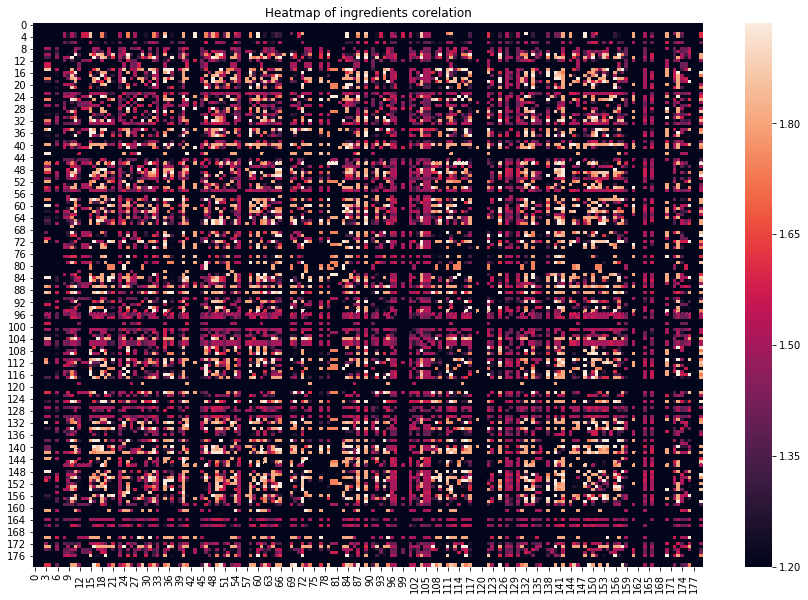

In [16]:
cor_map = np.load("_models_/_cor_map_/cormap.npy")
import seaborn as sns
plt.figure(figsize=(15,10))
cor_map = (cor_map + 1.2)
sns.heatmap(cor_map[:180,:180])
plt.title("Heatmap of ingredients corelation")
plt.show

cor_tensor = torch.tensor(cor_map).cpu()

In [17]:
from _models_._utils_ import Generator_cor_map
"""
model with corelation map loading

"""


generator = Generator_cor_map(matrix_for_embedding, cor_tensor,  LEN_SEQ,  n_tokens_ingr, emb_size=100, lstm_units=100, rand_inp=50).cpu()
chkpt_ = torch.load("_models_/_weights_/generator", map_location="cpu")
generator.load_state_dict(chkpt_)
generator.eval()
print()

## discription text generation model

In [18]:
from _models_._utils_ import text_generator2

"""

input : recipe ingridients:

output: disription tokenized

"""


text_generation = text_generator2(n_tokens_main,n_tokens_ingr, emb_size=300, \
                 lstm_units=500, emb_size2=200, lstm_units2=200).cpu()
chkpt = torch.load("_models_/_weights_/discription-Copy1", map_location="cpu")
text_generation.load_state_dict(chkpt)
text_generation.eval()  
print()


In [19]:
from _models_._utils_ import generate_text_direction


generate_text_direction(text_generation , array = [38,  72, 107,  74]  )

tensor([[  67,    6,  258,   17,  693,  153,    3,    7,    8,  515,   35,   87,
          258,  417,   21,   94,  174,   20,  147,   16,    3,   52,  105,   42,
          515,   35,    5,   72,  109,    9,   79,  244,   21,    6,  180,    3,
           14,  446,   18, 1423,    5,   87,   40,    9,  187,    7,    6,  515,
           35,    3,   14,  446,    3,   47,    5,   28,   21,  135,   15,  148,
          116,   18,  349,   51,  113,   41,   96,   11,  258,   33,  111,    3,
           52,  105,   42,  759,    5,   67,   17,  693,  153,   42,  901,   10,
            8,  737,  393,    3,  375,  759,    5,  412,    5,   67,  105,   17,
          693,  153,   10,    8]])

## eval with PCA FOR main model


In [20]:
from sklearn.decomposition import PCA, NMF , FactorAnalysis, TruncatedSVD,IncrementalPCA,KernelPCA , FastICA
from sklearn import manifold 
import pickle

pca1 = PCA(n_components=10)
pca2 = PCA(n_components=20)


pca1 = pickle.load(open("_models_/_weights_/pca1.sav", 'rb'))
pca2 = pickle.load(open("_models_/_weights_/pca2.sav", 'rb'))

# PCA functions
def pca1_forward(vec):
    vec1 = pca1.transform((vec))
    return(vec1)

def pca1_back(vec):
    vec1 = pca1.inverse_transform((vec))
    return(vec1)

def pca2_forward(vec):
    vec1 = pca2.transform((vec))
    return(vec1)

def pca2_back(vec):
    vec1 = pca2.inverse_transform((vec))
    return(vec1)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator PCA from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator PCA from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# SAMPLING

In [21]:
slovar_mean = dict()

def printing_hidden_pca(batch, label = "beef"):
    
    vec1 = model.dec(batch["ingridients_one_hot"])
    vec = pca1_forward(vec1.cpu().data.numpy())
    _mean_ = (vec).mean(axis = 0)
    _std_ = (vec).std(axis = 0)/4


    h1 = model.emb(batch["ingridients_one_hot"]).sum(dim = 1)
    h1 = model.cls(h1)
    h1_ = pca2_forward(h1.cpu().data.numpy())
    _mean_2 = (h1_).mean(axis = 0)
    _std_2 = (h1_).std(axis = 0)/4
    
    slovar_mean[label]= [_mean_, _std_, _mean_2, _std_2]
    
    #fig,axes = plt.subplots(ncols=2, figsize=(20,3))
    axes[0].plot(_mean_,lw=4, label = label)
    axes[0].fill_between(np.arange(10),_mean_ + _std_, _mean_ - _std_ , alpha=.2)
    axes[0].legend()
    axes[0].set(title='PCA decoding LSTM hidden')

    axes[1].plot(_mean_2,lw=4, label = label)
    axes[1].fill_between(np.arange(20),_mean_2 + _std_2, _mean_2 - _std_2 , alpha=.2)
    axes[1].legend()
    axes[1].set(title='PCA decoding Classification hidden')

slovar_mean_truth = dict()

def printing_hidden(batch, label = "beef"):
    
    vec1 = model.dec(batch["ingridients_one_hot"])
    vec = (vec1.cpu().data.numpy())
    _mean_ = (vec).mean(axis = 0)
    _std_ = (vec).std(axis = 0)/4


    h1 = model.emb(batch["ingridients_one_hot"]).sum(dim = 1)
    h1 = model.cls(h1)
    h1_ = (h1.cpu().data.numpy())
    _mean_2 = (h1_).mean(axis = 0)
    _std_2 = (h1_).std(axis = 0)/4
    
    slovar_mean_truth[label]= [_mean_,_std_, _mean_2,_std_2]
    
    #fig,axes = plt.subplots(ncols=2, figsize=(20,3))
    axes[0].plot(_mean_,lw=4, label = label)
    axes[0].fill_between(np.arange(30),_mean_ + _std_, _mean_ - _std_ , alpha=.2)
    axes[0].legend()
    axes[0].set(title='TRUTH decoding LSTM hidden')

    axes[1].plot(_mean_2,lw=4, label = label)
    axes[1].fill_between(np.arange(20),_mean_2 + _std_2, _mean_2 - _std_2 , alpha=.2)
    axes[1].legend()
    axes[1].set(title='TRUTH decoding Classification hidden')


# PCA hidden

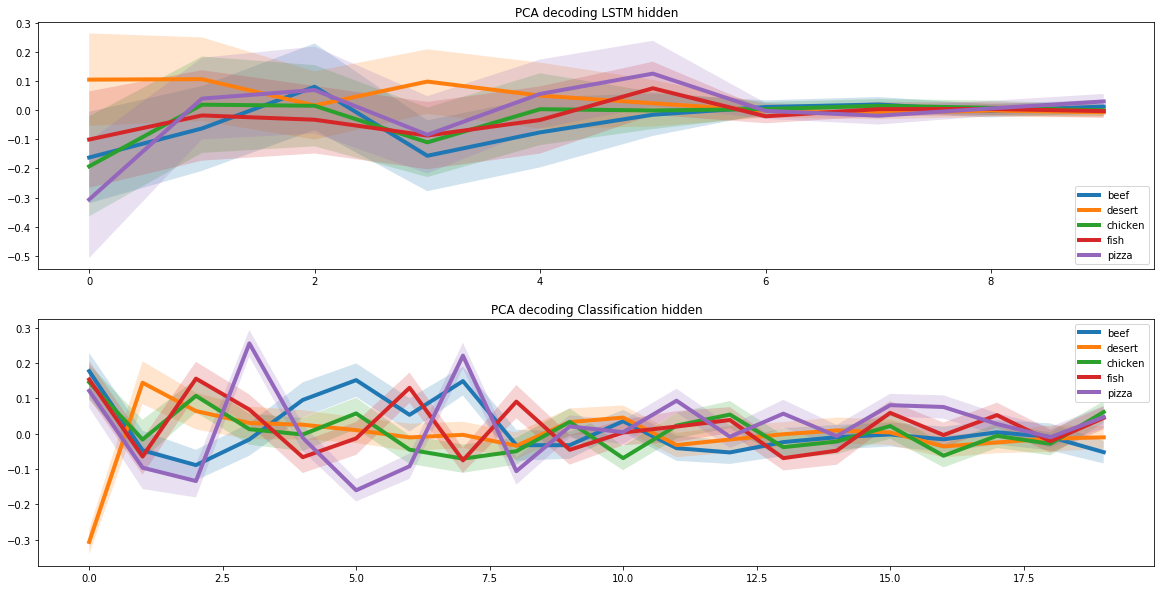

In [22]:
fig,axes = plt.subplots(nrows=2, figsize=(20,10))



if True:
    for batch in sample_data_batch(100, data_vectorized_beef, n_tokens_ingr , n_tokens_quant , n_tokens_how , LEN_SEQ):
        break
    printing_hidden_pca(batch, "beef")

    for batch in sample_data_batch(100, data_vectorized_des, n_tokens_ingr , n_tokens_quant , n_tokens_how , LEN_SEQ):
        break
    printing_hidden_pca(batch, "desert")

    for batch in sample_data_batch(100,  data_vectorized_chicken, n_tokens_ingr , n_tokens_quant , n_tokens_how , LEN_SEQ):
        break
    printing_hidden_pca(batch, "chicken")

    for batch in sample_data_batch(100,  data_vectorized_fish, n_tokens_ingr , n_tokens_quant , n_tokens_how , LEN_SEQ):
        break
    printing_hidden_pca(batch, "fish")


    for batch in sample_data_batch(100, data_vectorized_pizza, n_tokens_ingr , n_tokens_quant , n_tokens_how , LEN_SEQ):
        break
    printing_hidden_pca(batch, "pizza")

plt.show()

# truth hidden


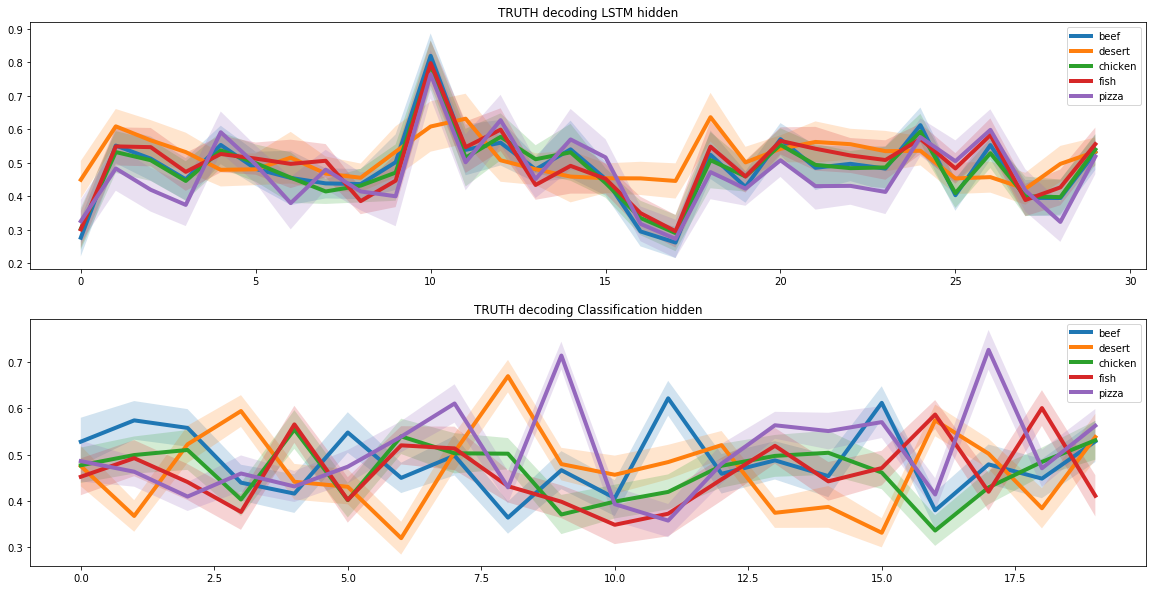

In [23]:
fig,axes = plt.subplots(nrows=2, figsize=(20,10))

if True:
    for batch in sample_data_batch(100, data_vectorized_beef, n_tokens_ingr , n_tokens_quant , n_tokens_how , LEN_SEQ):
        break
    printing_hidden(batch, "beef")

    for batch in sample_data_batch(100, data_vectorized_des, n_tokens_ingr , n_tokens_quant , n_tokens_how , LEN_SEQ):
        break
    printing_hidden(batch, "desert")

    for batch in sample_data_batch(100,  data_vectorized_chicken, n_tokens_ingr , n_tokens_quant , n_tokens_how , LEN_SEQ):
        break
    printing_hidden(batch, "chicken")

    for batch in sample_data_batch(100,  data_vectorized_fish, n_tokens_ingr , n_tokens_quant , n_tokens_how , LEN_SEQ):
        break
    printing_hidden(batch, "fish")

    for batch in sample_data_batch(100, data_vectorized_pizza, n_tokens_ingr , n_tokens_quant , n_tokens_how , LEN_SEQ):
        break
    printing_hidden(batch, "pizza")

plt.show()

## recipe generation

In [24]:
def sample_noise_batch(batch_size = 33, noize_dim=50):
    noise = torch.randn(batch_size, noize_dim)
    return noise
kof = np.arange(10,40)/40

In [25]:
def textizer(ingridients):
    data_for_text = [1]
    for ingt in ingridients:
        if ingt!= 0:
            data_for_text.append(ingt)
    data_for_text.append(2)
    
    
    text_discr = generate_text_direction(text_generation, data_for_text)
    text_it_main = text_discr[0].cpu().data.numpy()
    text_it_main = text_it_main[len(data_for_text)+1:]
    
    text_it_main = [i for i in text_it_main if i not in [0,1,2] ]
    discr = [num_to_main[inh] for inh in text_it_main]
    
    return(discr)

#textizer([12,4,6,8,4,6,0,0,0,0])[:10]

In [26]:
def printing_(label = "beef", ingrs = []):
    [_mean_,_std_, _mean_2, _std_2] = slovar_mean[label]
    [_mean_truth,_std_truth, _mean_2truth, _std_2truth] = slovar_mean_truth[label]
    
    kof = np.arange(10,30)/30
    noize1 = (sample_noise_batch(1, noize_dim=10)).cpu().data.numpy()   
    noize1 = np.tanh(noize1)
    noize_tensor1 = (_mean_  +  1.4*_std_* (noize1[0]))
    
    noize2 = (sample_noise_batch(1, noize_dim=20)).cpu().data.numpy()   
    noize2 = np.tanh(1*noize2)
    noize_tensor2 = (_mean_2  + 0.8*_std_2* (noize2[0]))
    
    hiden1 = pca1_back(noize_tensor1[None]) #+ _mean_truth[None]
    hiden2 = pca2_back(noize_tensor2[None]) #+ _mean_2truth[None]

    #hiden1 = (_mean_truth[None]) #+ _mean_truth[None]
    #hiden2 = (_mean_2truth[None]) #+ _mean_2truth[None]
    
    
    hiden1= torch.tensor(hiden1).float().cpu()
    hiden2= torch.tensor(hiden2).float().cpu()
    
    ingridient_s_tensor = torch.zeros(1,20).cpu()
    ingridient_s_tensor[:,0] = 1
    
    for iiii, ingrs_ in enumerate(ingrs):
        ingridient_s_tensor[:iiii+1] = ingr_to_num[ingrs_]
        #print("tyt")
    
    generator.dop = len(ingrs)
    model.enc.dop = len(ingrs)
    result = generator(hiden1, hiden2, ingridient_s_tensor.long())
    
    ingrid = (result["ingridients"].argmax(2))
    encod_res = one_hot_encoding(ingrid, n_tokens_ingr, 1 , LEN_SEQ)
    encod_ress = torch.cat([encod_res,encod_res,encod_res,encod_res])
    #img = image_generator(encod_ress).data.cpu().numpy().transpose([0, 2, 3, 1])
    
    #plt.imshow(img, cmap="gray")
    #plt.show()
    numbers = mod_numbers.forward(encod_res)
    how = mod_how.forward(encod_res)

    
    frame = pd.DataFrame(columns = ["__ingr", "__quant"  , "__how"])
    ingridients = result['ingridients'][0].argmax(1).cpu().data.numpy()
    
    discr = textizer(ingridients)
    
    quantity = numbers[0].argmax(1).cpu().data.numpy()
    how_coook = how[0].argmax(1).cpu().data.numpy()
    for idx in range(LEN_SEQ):
        a1,a2,a3 = num_to_ingr[ingridients[idx]], \
                    num_to_quant[quantity[idx]], \
                    num_to_how[how_coook[idx]]
        if idx <  len(ingrs):
            a1 = ingrs[idx]
        frame.loc[idx] = [a1,a2,a3]
        if  a1 == "":
            break
    return (frame, discr)

def text_varx(data, discr):
    main = []
    main.append(''.join(["."] * 70))
    
    
    recept = (', '.join(data.__ingr))
    
    for str_num in range(len(data )-1):
        ingr = data.iloc[str_num][0]
        kol = data.iloc[str_num][1]
        how = data.iloc[str_num][2]
        wh = qantyty_measure[ingr_to_num[ingr]]
        
        text_big = ["."] * 70
        for i in range(len(ingr)):
            text_big[i+3] = ingr[i]

        if kol!= "":
            for i in range(len(str(kol))):
                text_big[21+i] = str(kol)[i]
            
            if wh!= "":
                for i in range(len(wh)):
                    text_big[26+i] = (wh)[i]        
        
        for i in range(len(how)):
            try:
                text_big[i +33] = how[i]
            except:
                pass
        main.append(''.join(text_big))
    rec_len = len(main) -1
    if len(main)< 11:
        main.append(''.join(["."] * 70))
        main.append(''.join(["."] * 70))
    if TEST_DISCR:    
        main.append(''.join(["."] * 70))
        discr = ' '.join(discr)
        discr = discr.split(" . ")
        for idd,disc in enumerate(discr):
            s4et =0 
            main.append("{}.".format(idd))
            while True:
                main.append(disc[s4et:s4et+70])
                s4et +=70
                if s4et > len(disc):
                    break
    main.append(''.join(["."] * 70))
    return (main, rec_len , recept)

def text_var2(main ):
    return("\n".join(main))


In [27]:
TEST_DISCR = True
for idg in range(1):
    print("-------------------------------------")
    print()
    print(text_var2(text_varx(*printing_(label = "desert", ingrs = []))[0]))
    print()

-------------------------------------

......................................................................
...almond............1.0..c......slivered.............................
...milk..............1.0..c......evaporated...........................
...butter............0.5..tb.....melted...............................
...orange............1.0..ts.....grated...............................
...orange_juice......1.0..c......squeezed.............................
...vanilla...........1.0..ts.....flavored.............................
...egg...............4.0..ea.....separated............................
...sugar.............0.5..c......powdered.............................
......................................................................
......................................................................
......................................................................
0.
and juice in a food processor or blender
1.
process until smooth with your fingers until it forms a paste 

## Picture crating

In [28]:
from PIL import ImageFont
font = ImageFont.truetype("_utils_/Anonymous_Pro.ttf", size=15)
font2 = ImageFont.truetype("_utils_/Anonymous_Pro.ttf", size=20)
from PIL import Image, ImageDraw
from PIL import ImageFilter
from IPython.display import clear_output


import PIL
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [29]:
def pixelator(number_all):
    pixels_path = "pixels"

    all_indexes = np.arange(20)


    np.random.shuffle(all_indexes)
    current_indexes = all_indexes[:number_all]

    img = Image.new('RGB', (256, 256), color = (150, 150, 150))


    map_pix = np.random.randint(number_all, size=(8, 8))

    for i in range(8):
        for j in range(8):
            number = map_pix[i,j]

            img_name = os.path.join(pixels_path, str(current_indexes[number])+'.png')
            pix1 = Image.open( img_name).convert('RGB')

            img.paste(pix1, (32*i, 32*j) )

    img2 = Image.new('RGB', (32, 32*number_all), color = (150, 150, 150))
    for i in range(number_all):
        
        img_name = os.path.join(pixels_path, str(current_indexes[i])+'.png')
        pix1 = Image.open( img_name).convert('RGB')

        img2.paste(pix1, (0, 32*i) )    
    
    return(img, img2)





'tomato, bread, cream, water, butter, pepper, beef, sauce, pork, garlic, apple, oil, plum, licorice, brandy, watercress, rutabaga, cherry, filbert, asparagus'

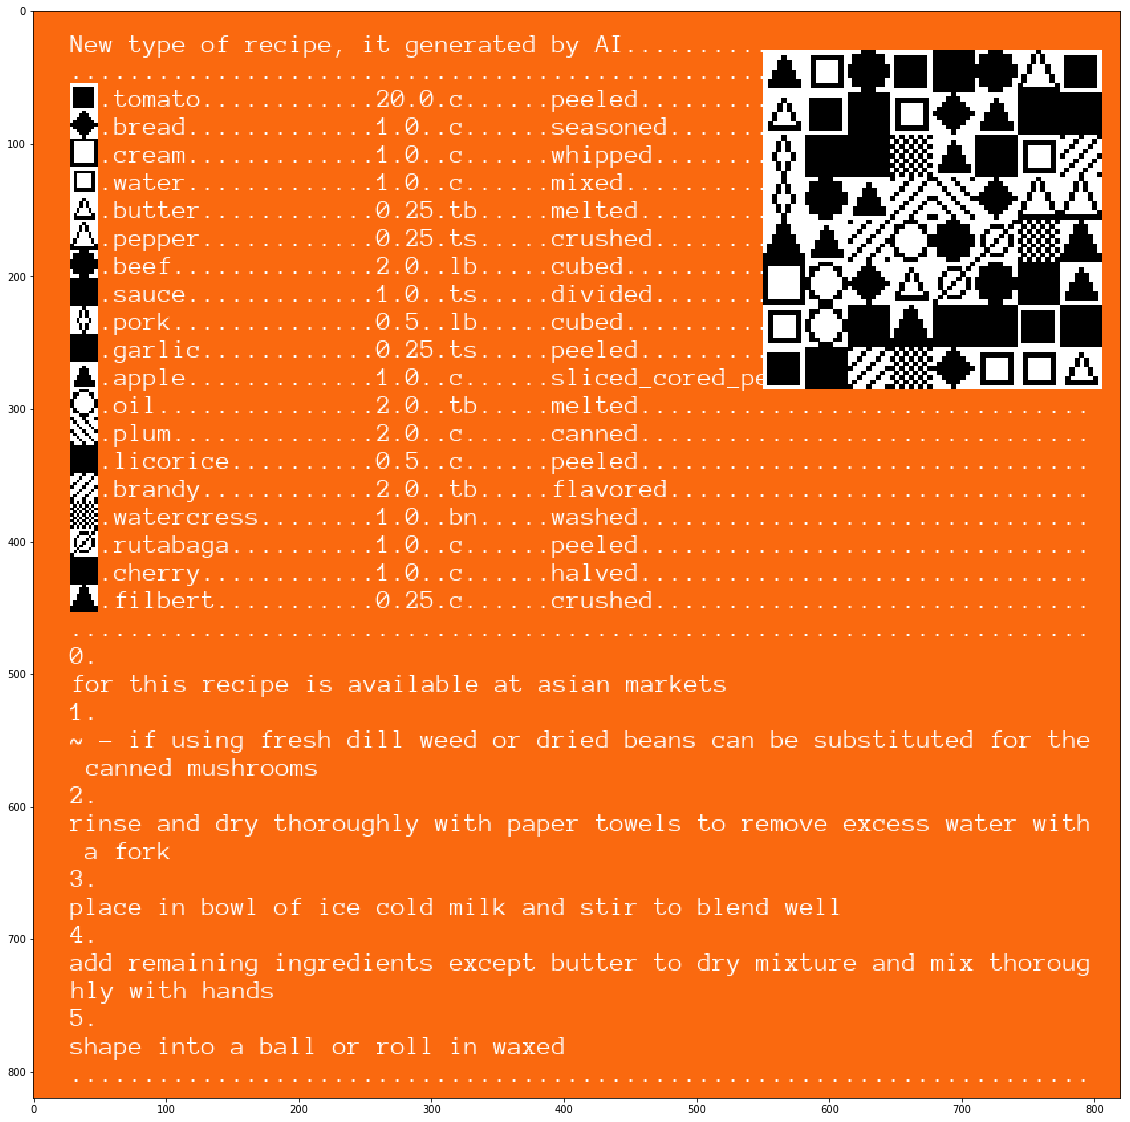

In [30]:
from PIL import ImageEnhance  

plt.figure(figsize=(20,20))
example, len_rec, recept= (text_varx(*printing_()))
def picture_creating(example, len_rec, recept):
    
    hight = (len(example) + 4) *20 
    pixels,pixels_wieght  = pixelator(len_rec)
    
    #[recipe_im1,recipe_im2,recipe_im3,recipe_im4] = [Image.fromarray(np.uint8(masker((images[_k]*255))), "RGB") for _k in range(4)]
    #[recipe_im1,recipe_im2,recipe_im3,recipe_im4] = [rec.resize((106,106)) for rec in [recipe_im1,recipe_im2,recipe_im3,recipe_im4]]
    #[recipe_im1,recipe_im2,recipe_im3,recipe_im4] = [rec.filter(ImageFilter.GaussianBlur(1)) for rec in [recipe_im1,recipe_im2,recipe_im3,recipe_im4]]

    img = Image.new('RGB', (820, hight ), color = (250, 105, 15))
    
    d = ImageDraw.Draw(img)
    d.text((28,15), "New type of recipe, it generated by AI................................", fill=(255,255,255),font = font2)
    Y =   35
    d.text((28,Y), text_var2(example), fill=(255,255,255), font = font2)
    d.rectangle(((580, 30), (792, 242)), fill=(50, 50, 50))
    
    
    
    #recipe_im1 = ImageEnhance.Contrast(recipe_im1).enhance(1.2) 
    #d.rectangle(((586, 36), (786, 236)), fill="white")
    img.paste(pixels, (550, 30))
    
    maxsize = (21, len_rec*21)
    
    
    img.paste(pixels_wieght.resize(maxsize), (28, 55))

    #img.paste(recipe_im2, (686, 30))
    #img.paste(recipe_im3, (580, 136))
    #img.paste(recipe_im4, (686, 136))

    #d.rectangle(((586, 36), (786, 236)), fill=(0,0,0))
    
    img.save('pil_text.png')
    plt.imshow(img)
    return(recept)
    
#print(image.shape)  
picture_creating(*text_varx(*printing_()))
